In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import xmltodict
import base64
import numpy as np
import array

from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_auc_score
from IPython.display import clear_output

# Data Preprocessings

In [3]:
def get_lead(path):
    with open(path, 'rb') as xml:
        ECG = xmltodict.parse(xml.read().decode('utf8'))
    
    augmentLeads = True
    if path.split('/')[-1][0] == '5':
        waveforms = ECG['RestingECG']['Waveform'][1]
    elif path.split('/')[-1][0] == '6':
        waveforms = ECG['RestingECG']['Waveform']
        augmentLeads = False
    else:
        waveforms = ECG['RestingECG']['Waveform']
    
    leads = {}
    
    for lead in waveforms['LeadData']:
        lead_data = lead['WaveFormData']
        lead_b64  = base64.b64decode(lead_data)
        lead_vals = np.array(array.array('h', lead_b64))
        leads[ lead['LeadID'] ] = lead_vals
    
    if augmentLeads:
        leads['III'] = np.subtract(leads['II'], leads['I'])
        leads['aVR'] = np.add(leads['I'], leads['II'])*(-0.5)
        leads['aVL'] = np.subtract(leads['I'], 0.5*leads['II'])
        leads['aVF'] = np.subtract(leads['II'], 0.5*leads['I'])
    
    return leads

In [6]:
error_files = ['6_2_003469_ecg.xml', '6_2_003618_ecg.xml', '6_2_005055_ecg.xml', '8_2_001879_ecg.xml', '8_2_002164_ecg.xml', '8_2_007281_ecg.xml', '8_2_008783_ecg.xml', '8_2_007226_ecg.xml']


train_data = []
train_labels = []
valid_data = []
valid_labels = []


train_pathes = ['data/train/arrhythmia/', 'data/train/normal/']
valid_pathes = ['data/validation/arrhythmia/', 'data/validation/normal/']

error_decode = []   # 디코딩에 실패한 데이터들..

for idx1, pathes in enumerate([train_pathes, valid_pathes]):
    
    for path in pathes:
        for file in os.listdir(path):

            if file in error_files or 'ipynb' in file:
                continue

            try:
                data = get_lead(path + file)
            except Exception as e:
                print(e)
                error_decode.append(path + file)

            listed_data = []
            keys = sorted(data.keys())
            for key in keys:
                listed_data.append(data[key])

            for idx2, i in enumerate(listed_data):
                if len(i) != 5000:
                    listed_data[idx2] = np.append(i, np.zeros(5000-len(i)))

                    
            # save each train, valid data
            if idx1== 0: 
                train_data.append(listed_data)
                if 'arrhythmia' in path:
                    train_labels.append(1)
                else:
                    train_labels.append(0)
            else:
                valid_data.append(listed_data)
                if 'arrhythmia' in path:
                    valid_labels.append(1)
                else:
                    valid_labels.append(0)

print(len(error_decode))


argument should be a bytes-like object or ASCII string, not 'NoneType'
argument should be a bytes-like object or ASCII string, not 'NoneType'
argument should be a bytes-like object or ASCII string, not 'NoneType'
argument should be a bytes-like object or ASCII string, not 'NoneType'
argument should be a bytes-like object or ASCII string, not 'NoneType'
argument should be a bytes-like object or ASCII string, not 'NoneType'
argument should be a bytes-like object or ASCII string, not 'NoneType'
bytes length not a multiple of item size
8


In [7]:
error_lead_len = []
for idx, i in enumerate(train_data):
    if len(i) != 12:
        error_lead_len.append(idx)
for i in error_lead_len:
    del train_data[i]
    del train_labels[i]
    

# 데이터 길이 및 lead 개수 분석

 데이터의 길이 분포 확인: valid는 모두 5000인것을 확인
 
 train은 60912개가 4999, 36개가 1249, 1개가 4988
 
 위의 테스크는 먼저 4999개만 0의 패딩을 붙이고 나머지는 제외하는식으로 전처리함
딱 한개의 9 lead의 데이터가 존재한다..

## 데이터 시각화
특정 데이터의 12개 lead를 모두 차트로 출력한다.  
각 lead들은 Moving average로 Data Smoothing 과정을 거친다.

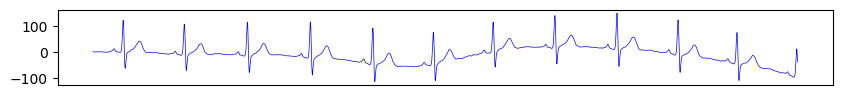

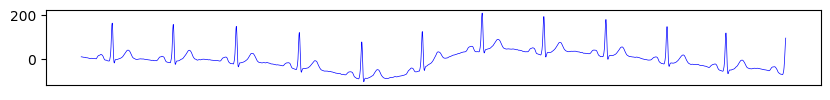

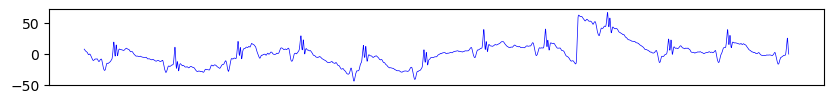

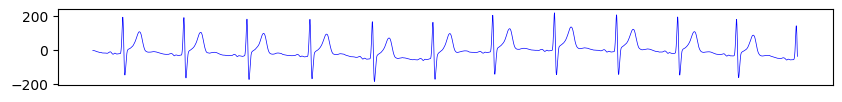

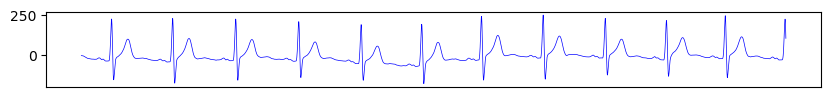

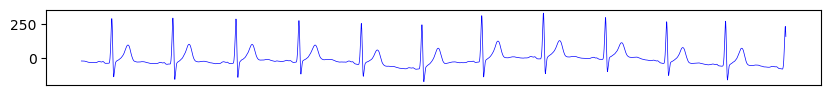

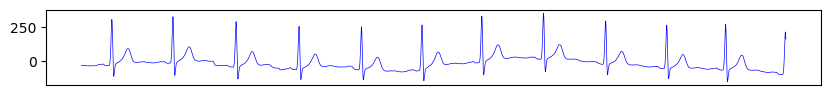

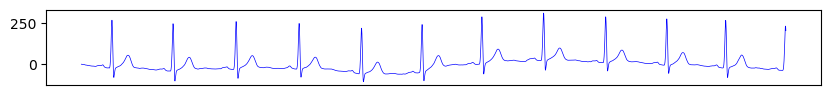

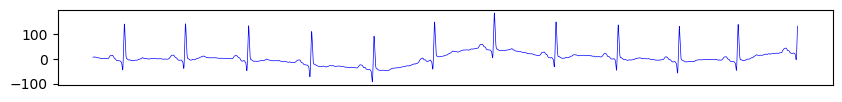

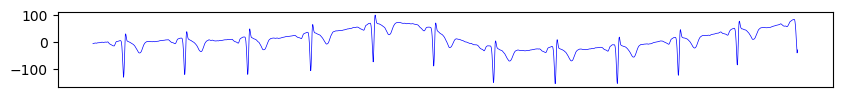

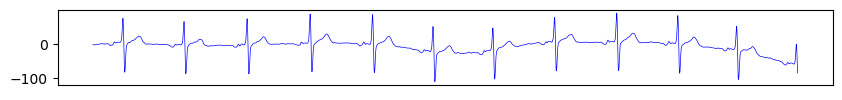

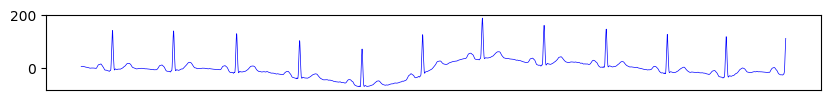

In [8]:
import matplotlib.pyplot as plt

def view_lead(leads):
    size = 5 # window size
    
    for key, lead in leads.items():
        amplitude = []
        
#         for i in range(0, len(lead), 5):
#             amplitude[i+1:i+5] = (amplitude[i]+amplitude[min(len(lead)-1, i+5)])/2

        ## Smoothing (Moving Average)
        for i in range(size, len(lead)-size):
            window = lead[i-size:i+size+1]
            amplitude.append(sum(window)/len(window))
        time = np.arange(0, len(amplitude))
        
        plt.figure(num=1, dpi=100, facecolor='white', figsize=(10,1), linewidth=5.0)
        plt.plot(time, amplitude, color='blue', linewidth=0.5)
        
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        plt.show()

        
view_lead(data)

# Dataset 생성

In [5]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels))
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(valid_data).float(), torch.tensor(valid_labels))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_21982/498780499.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/torch/csrc/utils/tensor_new.cpp:201.)
  train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels))


In [21]:
# residual과 dropout 추가 필요
class Classifier(nn.Module):
    def __init__(self, drop_out=0.0):
        super(Classifier,self).__init__()
        self.cnn1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5, padding=2) 
        self.cnn2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.cnn3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
    
        self.pool1 = nn.MaxPool1d(4)
        self.pool2 = nn.MaxPool1d(5)
        self.pool3 = nn.MaxPool1d(5)
    
        self.fc1 = nn.Linear(128 * 50, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        
        
        self.relu = nn.ReLU()
        
        self.drop_out = nn.Dropout(p=drop_out)
        
        
    def forward(self, x):
        x = self.relu(self.cnn1(x))
        x = self.pool1(x)
        x = self.relu(self.cnn2(x))
        x = self.pool2(x)
        x = self.relu(self.cnn3(x))
        x = self.pool3(x)

        x = x.view(-1, 128*50)
        
        x = self.relu(self.fc1(x))
        x = self.drop_out(x)
        x = self.relu(self.fc2(x))
        x = self.drop_out(x)
        x = self.relu(self.fc3(x))
        x = self.drop_out(x)
        x = self.relu(self.fc4(x))
        
        x = torch.sigmoid(x)
        
        return x.view(-1)
        


In [30]:
# Hyperparameter
drop_out = 0.3
l2_norm = 1e-6
lr = 0.00005


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Classifier(drop_out=drop_out).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_norm)
criterion = nn.BCELoss()


In [31]:
epoches = 200

best_auc = 0
best_epoch = -1
best_pred = []

prev_model = None

for i in range(epoches):
    
    # Train
    loss_sum = 0
    true_labels = []
    pred_labels = []
    model.train()
    for e_num, (x,y) in enumerate(train_dataloader):
        x, y = x.type(torch.FloatTensor).to(device), y.type(torch.FloatTensor).to(device)
        model.zero_grad()
        pred_y = model(x)
        
        loss=criterion(pred_y,y)
        loss_sum+=loss.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))
        
        
    acc=accuracy_score(true_labels,pred_labels)
    auc = roc_auc_score(true_labels,pred_labels)
    print(f'epoch: {i}')
    print(f'train \t loss mean {loss_sum/e_num : .4f}, auc_score : {auc : .4f}, accuracy: {acc : .4f} ')
    
    # Valid
    loss_sum=0
    true_labels=[]
    pred_labels=[]
    model.eval()
    for e_num, (x,y) in enumerate(val_dataloader):
        x, y = x.type(torch.FloatTensor).to(device), y.type(torch.FloatTensor).to(device)

        pred_y = model(x)
        loss=criterion(pred_y,y)
        
        loss_sum+=loss.detach()
        
        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(np.around(pred_y.cpu().detach().numpy()))
        
    
    wrong = []
    for k in len(pred_labels):
        wrong.append(true_lables[k] == pred_labels[k])
    wrong = [z for z, x in enumerate(wrong) if x]
        
    acc = accuracy_score(true_labels,pred_labels)
    auc = roc_auc_score(true_labels,pred_labels)
    
    print(f'validataion \t loss mean {loss_sum/e_num : .4f}, auc_score : {auc : .4f}, accuracy: {acc : .4f} ')
    if auc > best_auc:
        print("NEW RECODE!", end='\n\n')
        best_pred = pred_labels
        best_auc = auc
        best_epoch = i
        
        
        if prev_model is not None:
            os.remove(prev_model)
        prev_model = f'cnn_model_{best_auc : .4f}.h5'
        torch.save(model.state_dict(), prev_model)

print(f'best validation acc = {best_auc : .4f}, in epoch {best_epoch}')

epoch: 0
train 	 loss mean  0.6938, auc_score :  0.4998, accuracy:  0.5408 
validataion 	 loss mean  0.6977, auc_score :  0.5000, accuracy:  0.5413 
NEW RECODE!

epoch: 1
train 	 loss mean  0.6937, auc_score :  0.5000, accuracy:  0.5411 
validataion 	 loss mean  0.6977, auc_score :  0.5000, accuracy:  0.5413 
epoch: 2
train 	 loss mean  0.6937, auc_score :  0.5000, accuracy:  0.5411 
validataion 	 loss mean  0.6977, auc_score :  0.5000, accuracy:  0.5413 
epoch: 3
train 	 loss mean  0.6937, auc_score :  0.5000, accuracy:  0.5411 
validataion 	 loss mean  0.6977, auc_score :  0.5000, accuracy:  0.5413 
epoch: 4
train 	 loss mean  0.6937, auc_score :  0.5000, accuracy:  0.5411 
validataion 	 loss mean  0.6977, auc_score :  0.5000, accuracy:  0.5413 
epoch: 5
train 	 loss mean  0.6937, auc_score :  0.5000, accuracy:  0.5411 
validataion 	 loss mean  0.6977, auc_score :  0.5000, accuracy:  0.5413 
epoch: 6
train 	 loss mean  0.6937, auc_score :  0.5000, accuracy:  0.5411 
validataion 	 los

In [15]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [16]:
import  matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fper, tper, thresholds = roc_curve(true_labels,best_acc_pred)
plot_roc_curve(fper, tper)

ModuleNotFoundError: No module named 'matplotlib'